In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import tensorflow as tf
import keras
import warnings

warnings.filterwarnings('ignore')

In [3]:

DATASET_PATH = r"./dataset/"
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
dataset_folders = []
total = 0
print(f"There are {len(os.listdir(DATASET_PATH))} folder in dataset.")
for path in sorted(os.listdir(DATASET_PATH)):
    print(f"\t-There are {len(os.listdir(DATASET_PATH + path))} images in {path} folder.")
    total += len(os.listdir(DATASET_PATH + path))
    folder_path = DATASET_PATH + path
    dataset_folders.append(folder_path)

df = pd.DataFrame(0,
                  columns=['paths',
                           'class-label'],
                  index=range(total))
i = 0
for p, path in enumerate(dataset_folders):
    for sub_path in sorted(os.listdir(path)):
        df.iloc[i, 0] = path + "/" + sub_path
        df.iloc[i, 1] = p
        i += 1
# class labels in dataframe
# normal->0
# cataract->1
# glaucoma->2
# retina->3



There are 4 folder in dataset.
	-There are 300 images in 1_normal folder.
	-There are 100 images in 2_cataract folder.
	-There are 101 images in 2_glaucoma folder.
	-There are 100 images in 3_retina_disease folder.


In [4]:
#To see content of data frame
print(df.sample(frac=1).head(10))

                                         paths  class-label
75               ./dataset/1_normal/NL_076.png            0
222              ./dataset/1_normal/NL_223.png            0
190              ./dataset/1_normal/NL_191.png            0
491      ./dataset/2_glaucoma/Glaucoma_092.png            2
218              ./dataset/1_normal/NL_219.png            0
530  ./dataset/3_retina_disease/Retina_030.png            3
44               ./dataset/1_normal/NL_045.png            0
421      ./dataset/2_glaucoma/Glaucoma_022.png            2
150              ./dataset/1_normal/NL_151.png            0
366      ./dataset/2_cataract/cataract_067.png            1


# Pre-processing
Image preprocessing techniques are methods used to improve the quality and consistency of an image before it is used in a computer vision algorithm. These techniques can include things like adjusting the brightness or contrast of the image, removing noise or artifacts, and resizing or cropping the image to focus on the most important features. Some common image preprocessing techniques include histogram equalization, blurring, and thresholding. These techniques can help to make an image more suitable for analysis by a computer vision algorithm, and can improve the accuracy and performance of the algorithm.

# Image Normalization
Image normalization is a process in which the values of pixels in an image are adjusted so that they fall within a specific range, typically between 0 and 1 or between -1 and 1. There are several different techniques that can be used to perform image normalization, including scaling, centering, and standardization.

Scaling is a technique in which the values of the pixels in an image are multiplied by a constant value, resulting in an image with pixel values that are larger or smaller than the original. This can be useful for adjusting the contrast of an image, as well as for bringing the values of the pixels within a specific range.

Centering is a technique in which the values of the pixels in an image are shifted so that the mean value of the pixels is zero. This can be useful for removing the overall brightness or darkness of an image, and for making it easier to analyze the image using statistical techniques.

Standardization is a technique in which the values of the pixels in an image are transformed so that they have a mean of zero and a standard deviation of one. This can be useful for making the values of the pixels in an image comparable to those in other images, and for making it easier to perform certain types of analysis on the image.

Other techniques for image normalization include histogram equalization, which adjusts the contrast of an image by spreading out the most common pixel values, and min-max normalization, which scales the values of the pixels in an image to fall within a specified range.

## Seam Carving
Seam-carving is an image resizing technique that involves removing pixels from an image in a way that is intended to preserve the most important features of the image. It is often used for content-aware image resizing, where the goal is to resize an image without distorting the most important objects in the image.

In [5]:
# Split dataframe to train and test data
SEED = 42
df_train, df_test = train_test_split(df.sample(frac=1), test_size=0.2, random_state=SEED, stratify=df['class-label'])

In [6]:
#normalizes the histogram of images
def normalize_histograms(img):
    image_copy = img.copy()
    for i in range(3):
        imi = img[:, :, i]
        minval = np.min(imi)
        maxval = np.max(imi)
        imrange = maxval - minval
        # imi-minval will turn the color range between 0-imrange, and the scaling will stretch the range between 0-255
        image_copy[:, :, i] = (255 / (imrange + 0.0001) * (imi - minval))
    return image_copy


#Cropping image to avoid from unuseful black areas
def deleteBlackAreas(filename):
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
    img = cv2.imread(filename)  #read image from file
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)  # turn it into a binary image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # find contours
    if len(contours) != 0:
        #find the biggest area
        cnt = max(contours, key=cv2.contourArea)

        #find the bounding rect
        x, y, w, h = cv2.boundingRect(cnt)

        crop = img[y:y + h, x:x + w]  # crop image
        crop1 = cv2.cvtColor(cv2.resize(crop, image_size, interpolation=cv2.INTER_AREA),
                             cv2.COLOR_BGR2RGB)  # resize to image_size and change color space from BGR to RGB for matplotlib
        return crop1
    else:
        return cv2.resize(img, image_size, interpolation=cv2.INTER_AREA)

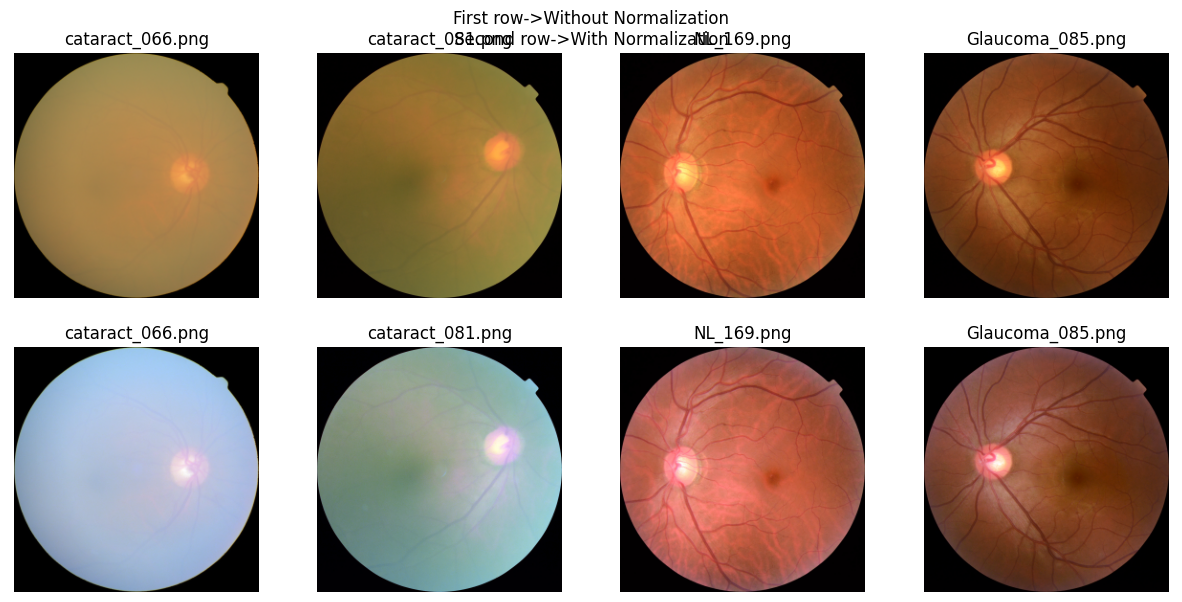

In [7]:
#Display Random 4 image to see what we have up to now
np.random.seed(SEED)
randoms = np.random.randint(0, len(df_train), 4)
fig = plt.figure(figsize=(15, 7))
plt.title("First row->Without Normalization\nSecond row->With Normalization")
plt.axis('off')
plt.grid(False)
for i in range(4):
    fig.add_subplot(2, 4, i + 1)
    img = deleteBlackAreas(df_train.iloc[randoms[i]]["paths"])
    plt.axis('off')
    plt.title(df_train.iloc[randoms[i]]["paths"].split("/")[3])
    plt.imshow(img)

    fig.add_subplot(2, 4, i + 5)
    img2 = normalize_histograms(img)
    plt.axis('off')
    plt.title(df_train.iloc[randoms[i]]["paths"].split("/")[3])
    plt.imshow(img2)



In [8]:
# Creating dataset
images = []
labels = []
df = df.sample(frac=1)
for i in range(len(df)):
    filename = df.iloc[i]["paths"]
    img = deleteBlackAreas(filename)
    label = df.iloc[i]["class-label"]
    images.append(img)
    labels.append(label)

In [9]:
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=SEED)
# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

print("X_train shape: {}".format(np.array(X_train).shape))
print("X_test shape: {}".format(np.array(X_test).shape))
print("y_train shape: {}".format(np.array(y_train).reshape(-1, 1).shape))
print("y_test shape: {}".format(np.array(y_test).reshape(-1, 1).shape))
print("X_val shape: {}".format(np.array(X_val).shape))
print("y_val shape: {}".format(np.array(y_val).reshape(-1, 1).shape))

X_train shape: (360, 256, 256, 3)
X_test shape: (121, 256, 256, 3)
y_train shape: (360, 1)
y_test shape: (121, 1)
X_val shape: (120, 256, 256, 3)
y_val shape: (120, 1)


In [10]:
#Split the data into train and validation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                validation_split=0.2)

train_generator = train_datagen.flow_from_directory(DATASET_PATH,
                                                    target_size=(256, 256),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(DATASET_PATH,
                                                         target_size=(256, 256),
                                                         batch_size=32,
                                                         class_mode='categorical',
                                                         subset='validation')

Found 481 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [11]:
#Generated labels
labels = (train_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())
print(labels)

{0: '1_normal', 1: '2_cataract', 2: '2_glaucoma', 3: '3_retina_disease'}


In [12]:
#Creating base-model and freeze layers
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(256, 256, 3),
                                                     include_top=False,
                                                     weights='imagenet')
base_model.trainable = False

2022-12-15 20:45:52.849310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 20:45:52.849942: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/semooww/PycharmProjects/DSCP/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-15 20:45:52.850534: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/semooww/PycharmProjects/DSCP/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-15 20:45:52.850901: W tensorflow/compiler/xla/stream_executor/platfor

In [13]:
model_res = tf.keras.Sequential([base_model,
                                 tf.keras.layers.Conv2D(16, (3, 3), padding="same", activation="relu"),
                                 tf.keras.layers.MaxPooling2D(),  #Downsamples the input
                                 tf.keras.layers.Flatten(),  #Flattens the input and prepare for the dense layer
                                 tf.keras.layers.Dense(4, activation="softmax")])
model_res.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics="accuracy")

In [14]:
model_res.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 16)          294928    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 16)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 4)                 1028      
                                                                 
Total params: 23,883,668
Trainable params: 295,956
Non-trainable params: 23,587,712
______________________________________

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=[256, 256, 3]),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (2, 2), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (2, 2), padding="same", activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])


In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      8256      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        16448     
                                                                 
 flatten_3 (Flatten)         (None, 262144)           

In [23]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
history = model.fit(X_train, y_train.flatten(), batch_size=32, epochs=30, validation_data=(X_val, y_val.flatten()))
model.evaluate(X_test, y_test.flatten(), verbose=2)

Epoch 1/30
12/12 [==============================] - 19s 1s/step - loss: 901.3306 - accuracy: 0.3194 - val_loss: 9.4016 - val_accuracy: 0.5333
Epoch 2/30
12/12 [==============================] - 17s 1s/step - loss: 2.8198 - accuracy: 0.4167 - val_loss: 1.4546 - val_accuracy: 0.5333
Epoch 3/30
12/12 [==============================] - 17s 1s/step - loss: 1.3303 - accuracy: 0.4306 - val_loss: 1.3013 - val_accuracy: 0.5333
Epoch 4/30
12/12 [==============================] - 17s 1s/step - loss: 1.2328 - accuracy: 0.4750 - val_loss: 1.2760 - val_accuracy: 0.5250
Epoch 5/30
12/12 [==============================] - 17s 1s/step - loss: 1.2152 - accuracy: 0.4944 - val_loss: 1.2479 - val_accuracy: 0.5333
Epoch 6/30
12/12 [==============================] - 18s 2s/step - loss: 1.1726 - accuracy: 0.5028 - val_loss: 1.2105 - val_accuracy: 0.4917
Epoch 7/30
12/12 [==============================] - 18s 1s/step - loss: 1.1115 - accuracy: 0.5333 - val_loss: 1.2808 - val_accuracy: 0.4750
Epoch 8/30
12/12 [

[1.8841524124145508, 0.43801653385162354]

In [25]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

AttributeError: module 'keras' has no attribute 'history'